## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import required libraries


In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Download the DLIB Dataset

In [ ]:
%%capture  
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):  #if you already have the dataset downloaded just insert it using the given path
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

## Visualize the dataset

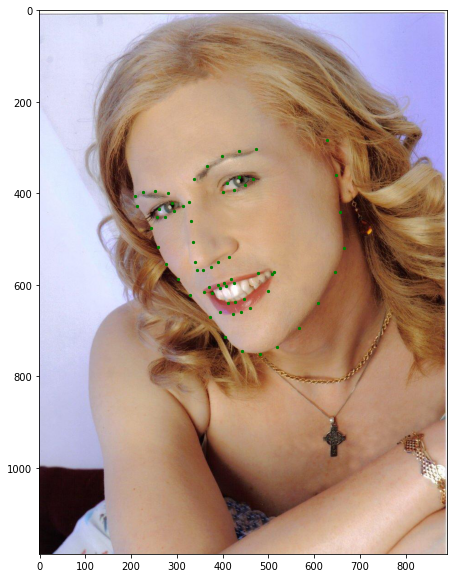

In [ ]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/1010057391_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/1010057391_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

## Create dataset class

In [ ]:
class Transforms():   # this class is used to transform our image into required shape and size 
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

## Visualize Train Transforms

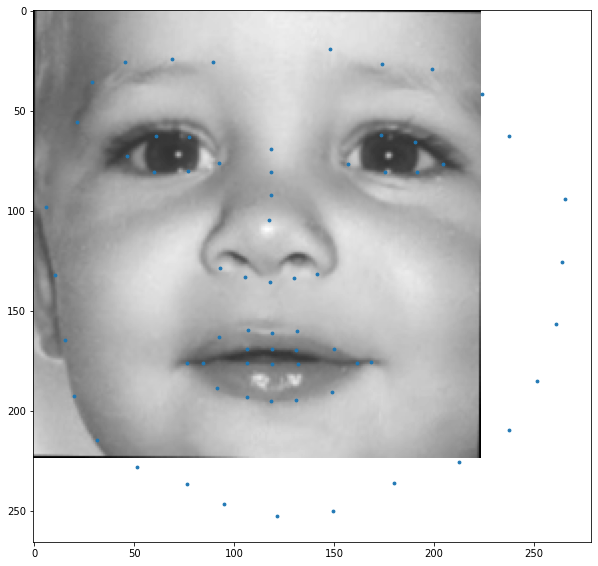

In [ ]:
image, landmarks = dataset[9]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

## Split the dataset into train and valid dataset

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Testing the shape of input data

In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


## Define the model

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

## Helper Functions

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

## Train

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid Steps: 84/84  Loss: 0.0063 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0193  Valid Loss: 0.0063
--------------------------------------------------

Minimum Validation Loss of 0.0063 at epoch 1/10
Model Saved

Valid Steps: 84/84  Loss: 0.0055 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0056  Valid Loss: 0.0055
--------------------------------------------------

Minimum Validation Loss of 0.0055 at epoch 2/10
Model Saved

Valid Steps: 84/84  Loss: 0.0045 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0046  Valid Loss: 0.0045
--------------------------------------------------

Minimum Validation Loss of 0.0045 at epoch 3/10
Model Saved

Valid Steps: 84/84  Loss: 0.0035 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0034  Valid Loss: 0.0035
--------------------------------------------------

Minimum Validation Loss of 0.0035 at epoch 4/10
Model Saved

Valid Steps:

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-07z2zjwp'


Valid Steps: 84/84  Loss: 0.0023 
--------------------------------------------------
Epoch: 7  Train Loss: 0.0018  Valid Loss: 0.0023
--------------------------------------------------
Valid Steps: 84/84  Loss: 0.0016 
--------------------------------------------------
Epoch: 8  Train Loss: 0.0015  Valid Loss: 0.0016
--------------------------------------------------

Minimum Validation Loss of 0.0016 at epoch 8/10
Model Saved

Valid Steps: 84/84  Loss: 0.0016 
--------------------------------------------------
Epoch: 9  Train Loss: 0.0014  Valid Loss: 0.0016
--------------------------------------------------
Valid Steps: 84/84  Loss: 0.0016 
--------------------------------------------------
Epoch: 10  Train Loss: 0.0013  Valid Loss: 0.0016
--------------------------------------------------

Minimum Validation Loss of 0.0016 at epoch 10/10
Model Saved

Training Complete
Total Elapsed Time : 6352.1590259075165 s


## Predict on Test Images
this doesnt work on your given image its only for the images on downloaded dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total number of test images: 666
Elapsed Time : 13.770058870315552


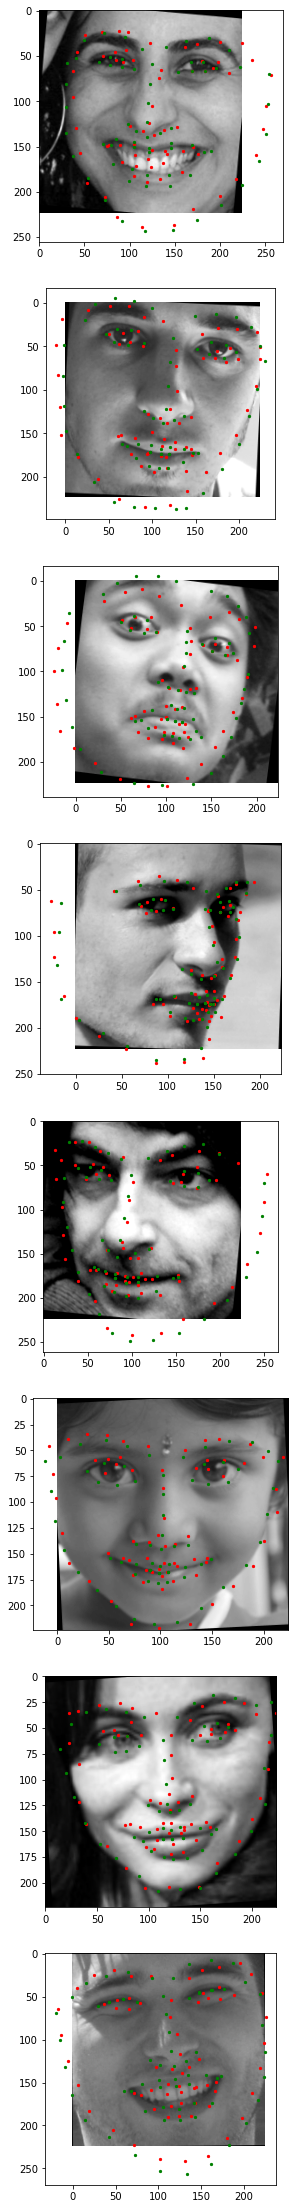

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/face_landmarks.pth'))    #load the saved model with the path you have saved onto
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

##visualization on own image

tensor([[-0.4352, -0.1065, -0.4390, -0.0073, -0.3931,  0.0629, -0.4065,  0.2382,
         -0.3559,  0.3054, -0.2813,  0.4153, -0.2197,  0.4657, -0.1187,  0.5669,
          0.0087,  0.5880,  0.0810,  0.5462,  0.1287,  0.4630,  0.1999,  0.4235,
          0.2904,  0.3059,  0.3257,  0.2406,  0.3486,  0.1114,  0.3800,  0.0374,
          0.3676, -0.0664, -0.3061, -0.1686, -0.2451, -0.1970, -0.1598, -0.2134,
         -0.0694, -0.1885, -0.0085, -0.1655,  0.0989, -0.1437,  0.1606, -0.1727,
          0.2273, -0.1989,  0.3289, -0.1893,  0.3670, -0.1233,  0.0333, -0.0959,
          0.0591, -0.0221,  0.0173,  0.0867,  0.0178,  0.1453, -0.0517,  0.1906,
         -0.0319,  0.1815,  0.0212,  0.2229,  0.0537,  0.2390,  0.1148,  0.1986,
         -0.2267, -0.0976, -0.1601, -0.1332, -0.1389, -0.1262, -0.1145, -0.0792,
         -0.1143, -0.0819, -0.1825, -0.0542,  0.1391, -0.0580,  0.1674, -0.1019,
          0.2191, -0.1262,  0.2985, -0.0946,  0.2129, -0.0465,  0.1769, -0.0853,
         -0.1444,  0.3136, -

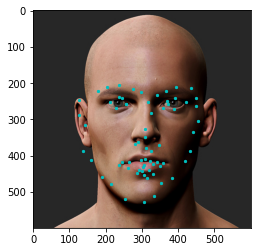

In [ ]:
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF
#######################################################################
image_path = '/content/man_face0.jpg'     # give the path for image you want to predict the landmarks
weights_path = '/content/drive/MyDrive/Datasets/face_landmarks.pth'     #path for the saved model
frontal_face_cascade_path ='/content/drive/MyDrive/Datasets/haarcascade_frontalface_default.xml'   # this is the face detection algorithm you can download it from github // search for haarcascade...
#######################################################################
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=False)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features,num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

#######################################################################
face_cascade = cv2.CascadeClassifier(frontal_face_cascade_path)

best_network = Network()
best_network.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'))) 
best_network.eval()

image = cv2.imread(image_path)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width,_ = image.shape

faces = face_cascade.detectMultiScale(grayscale_image, 1.1, 4)

all_landmarks = []
for (x, y, w, h) in faces:
    image = grayscale_image[y:y+h, x:x+w]
    image = TF.resize(Image.fromarray(image), size=(224, 224))
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])

    with torch.no_grad():
        landmarks = best_network(image.unsqueeze(0)) 
        # print(landmarks)    # this line of code is for the visulaization of array on how the landmarks are saved.

    landmarks = (landmarks.view(68,2).detach().numpy() + 0.5) * np.array([[w, h]]) + np.array([[x, y]])
    all_landmarks.append(landmarks)

plt.figure()
plt.imshow(display_image)
for landmarks in all_landmarks:
    plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)

plt.show()

#visulaization of eye landmarks using haarcascade eye data

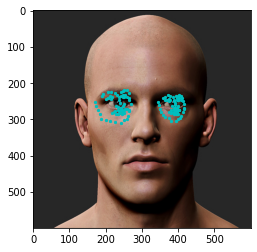

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF
#######################################################################
image_path = '/content/man_face0.jpg'
weights_path = '/content/drive/MyDrive/Datasets/face_landmarks.pth'
eye_cascade_path ='/content/drive/MyDrive/Datasets/haarcascade_eye_tree_eyeglasses.xml'
#######################################################################
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=False)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features,num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

#######################################################################
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

best_network = Network()
best_network.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'))) 
best_network.eval()

image = cv2.imread(image_path)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width,_ = image.shape

eyes = eye_cascade.detectMultiScale(grayscale_image, 1.1, 4)

all_landmarks = []
for (x, y, w, h) in eyes :
    image = grayscale_image[y:y+h, x:x+w]
    image = TF.resize(Image.fromarray(image), size=(224, 224))
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])

    with torch.no_grad():
        landmarks = best_network(image.unsqueeze(0)) 

    landmarks = (landmarks.view(68,2).detach().numpy() + 0.5) * np.array([[w, h]]) + np.array([[x, y]])
    all_landmarks.append(landmarks)

plt.figure()
plt.imshow(display_image)
for landmarks in all_landmarks:
    plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)

plt.show()

#code for  glasses tryon

In [ ]:
# defining the functon to get the starting and ending image points of eye
def plottingdata(all_landmarks):
  glass_width=[]
  glass_height=[]
  plot_list=[]
  for landmarks in all_landmarks:
    # print(landmarks)
    minvalue=np.min(landmarks,0)
    print(minvalue[0])
    glass_width.append(minvalue[0])
    print(minvalue[1])
    glass_height.append(minvalue[1])
    print(minvalue)
    for x in landmarks:
      if x[0]== minvalue[0]:
        plot_list.append(x)
      if  x[1]== minvalue[1] :
        plot_list.append(x) 


    maxvalue=np.max(landmarks,0) 
    print(maxvalue[0])
    glass_width.append(maxvalue[0])
    print(maxvalue[1])
    glass_height.append(maxvalue[1])
    print(maxvalue)
    for y in landmarks:
      if y[0]== maxvalue[0]:
        plot_list.append(y)
      if y[1]== maxvalue[1] :
        plot_list.append(y) 



   

  # print(plot_list)
  return plot_list , glass_width,  glass_height

173.99693816900253
179.31081327795982
[173.99693817 179.31081328]
226.7743581533432
230.2838797569275
[226.77435815 230.28387976]
281.81338262557983
173.13325834274292
[281.81338263 173.13325834]
339.48801040649414
224.1598768234253
[339.48801041 224.15987682]


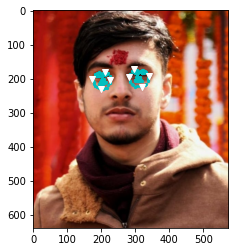

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF
#######################################################################
image_path = '/content/rajiv.jpg'
weights_path = '/content/drive/MyDrive/Datasets/face_landmarks.pth'
eye_cascade_path ='/content/drive/MyDrive/Datasets/haarcascade_eye_tree_eyeglasses.xml'
#######################################################################
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=False)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features,num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

#######################################################################
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

best_network = Network()
best_network.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'))) 
best_network.eval()

image = cv2.imread(image_path)

grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width,_ = image.shape

eyes = eye_cascade.detectMultiScale(grayscale_image, 1.1, 4)
# print(eyes)

all_landmarks = []
for (x, y, w, h) in eyes:
    image = grayscale_image[y:y+h, x:x+w]
    image = TF.resize(Image.fromarray(image), size=(224, 224))
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])

    with torch.no_grad():
        landmarks = best_network(image.unsqueeze(0)) 
      

    landmarks = (landmarks.view(68,2).detach().numpy() + 0.5) * np.array([[w, h]]) + np.array([[x, y]])
   


    all_landmarks.append(landmarks)
    


plt.figure()
plt.imshow(display_image)
points=[]
points, glass_width, glass_height=plottingdata(all_landmarks)

 ###################################################################################
# this line of code is used to visualize if we got the required points on the image eye /////// denoted by white marker in image
plt.plot(points[0][0], points[0][1], marker='v', color="white")
plt.plot(points[1][0], points[1][1], marker='v', color="white")
plt.plot(points[2][0], points[2][1], marker='v', color="white")
plt.plot(points[3][0], points[3][1], marker='v', color="white")
plt.plot(points[4][0], points[4][1], marker='v', color="white")
plt.plot(points[5][0], points[5][1], marker='v', color="white")
plt.plot(points[6][0], points[6][1], marker='v', color="white")
plt.plot(points[7][0], points[7][1], marker='v', color="white")

##################################################################################

for landmarks in all_landmarks:
    # print(landmarks)
    plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)   # denoted by cyan color in the image

plt.show()


In [ ]:
glass_width, glass_height # visualizing out plotting function items

([173.99693816900253,
  226.7743581533432,
  281.81338262557983,
  339.48801040649414],
 [179.31081327795982,
  230.2838797569275,
  173.13325834274292,
  224.1598768234253])

## this cell is used to get the points where shall we plot images of glassess.

In [ ]:
glasses_width=max(glass_width) - min(glass_width)+10
glasses_height=max(glass_height) - min(glass_height)+30

glasses_width=int(glasses_width)
glasses_height=int(glasses_height)

glasses_width,  glasses_height

(175, 87)

In [ ]:
# !pip install cvzone      #uncomment this if you have no cvzone installed

##image overlay code

[87, 175, 4]


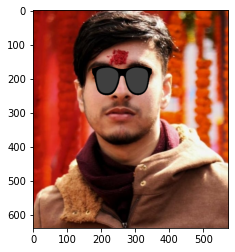

In [ ]:
import cv2 
import cvzone

glasses=cv2.imread("/content/glasses9.png", cv2.IMREAD_UNCHANGED)  #give the path of glasses image
glasses= cv2.resize(glasses, (glasses_width, glasses_height))

dimensions=list(glasses.shape)
print(dimensions)

imgresult=cvzone.overlayPNG(display_image, glasses, [int(min(glass_width)),int(min(glass_height)-10)])   #addition and subtraction is done for height adjustment of glasses

plt.imshow(imgresult)
